In [1]:
import numpy as np
import pandas as pd
import os
from IPython.display import clear_output
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
#How do I #define in python?
ETF_LIST = ['REM', 'REZ', 'IYR', 'ICF', 'REET', 'USRT']
BIN_MAP = [2**0, 2**1, 2**2, 2**3, 2**4, 2**5]

BIN_REM  = 0b000001
BIN_REZ  = 0b000010
BIN_IYR  = 0b000100
BIN_ICF  = 0b001000
BIN_REET = 0b010000
BIN_USRT = 0b100000
BIN_ERROR= 0b1000000

In [3]:
def sum_of_sq_diff(series1: np.array, series2: np.array):
    """
    Sum of square differences of the two series. 
    Must both be numpy arrays of the same size.
    """
    size = series1.__len__()
    assert size == series2.__len__(), f'Series 1 has size {size} while Series 2 has size {series2.__len__()}'

    #Check for normalization
    if np.max(series1) > 1.0:
        series1 = normalize_data(series1)
    if np.max(series2) > 1.0:
        series2 = normalize_data(series2)

    sum = 0
    for i in range(size):
        absdiff = abs(series1[i] - series2[i])
        absdiff**2
        sum += absdiff
    
    sum = sum / float(size)
    return sum

def normalize_data(series: np.array):
    """
    Returns the array with each entry divided by the series max.
    """
    max = np.max(series)
    return series/max

def string_to_list(string):
    """
    Creates a list based of the string given. 
    Use case is to make a list from excel string.
    """
    #Remove the leading and trailing [, ]
    string = string[1:-1]

    delimiter = ','

    list = []
    temp = ""
    for s in string:
        if s == "'":
            continue

        if s == delimiter:
            list.append(temp.strip())
            temp = ""
            continue
        temp = temp + s

    if temp.__len__() != 0:
        list.append(temp.strip())
    
    return list

def etf_to_bin(string):
    """
    Lazy method to convert etf string to a binary flag.
    """
    if string == 'REM': 
        return BIN_REM
    if string == 'REZ': 
        return BIN_REZ
    if string == 'IYR': 
        return BIN_IYR
    if string == 'ICF': 
        return BIN_ICF
    if string == 'REET': 
        return BIN_REET
    if string == 'USRT': 
        return BIN_USRT
    
    return BIN_ERROR

def get_sum_of_weights(G: nx.Graph, node):
    """
    Returns the sum of weights for a given node.
    """
    node_sum = nx.volume(G, node, weight='weight')
    return node_sum

In [4]:
#Getting data
df = pd.read_excel("Data\\ETF Refined\\Normalized Data.xlsx", header = 0)
stocks = np.ndarray((df.__len__(), df.iloc[0, 3:].__len__()))

#Extracting numpy array from excel sheet
for i in range(df.__len__()):
    np_row = df.iloc[i, 3:].to_numpy(dtype=float)
    stocks[i, :] = np_row

#Normalize stocks
for i, row in enumerate(stocks):
    stocks[i, :] = normalize_data(row)

#Getting sum of Squares
edge_weight = []
for i in range(stocks.shape[0]):
    for j in range(i+1, stocks.shape[0]):
        edge_weight.append((df['Ticker'][i], df['Ticker'][j], sum_of_sq_diff(stocks[i], stocks[j])))

In [5]:
#Graph Baby, oh yeah
G = nx.Graph()
G.add_nodes_from(df['Ticker'].to_list())

In [6]:
#Flag for etf classification
etf_flag = {}

for n, node in enumerate(G.nodes()):
    #Assign flag according to what ETFs the node is in
    flag = 0b0
    for etf in string_to_list(df.iloc[n, 1]):
        flag |= etf_to_bin(etf)
    
    etf_flag[node] = flag

nx.set_node_attributes(G, etf_flag, 'etf_flag')

In [7]:

G.add_weighted_edges_from(edge_weight)

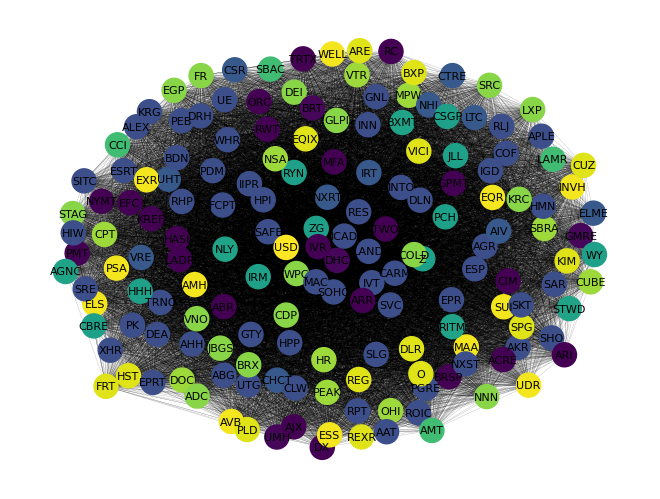

In [9]:
pos = nx.spring_layout(G, k=0.99, iterations=20)
flag_list = list(nx.get_node_attributes(G, 'etf_flag').values())
graph_draw = nx.draw(G, with_labels=True, pos = pos, font_size=8, width=0.075, node_color= flag_list, vmin = min(flag_list), vmax = max(flag_list))

In [9]:
for node, attributes in G.nodes(data=True):
    print(f"Node {node} \t Flag - {attributes['etf_flag']}")

Node WPC 	 Flag - 52
Node SHO 	 Flag - 16
Node MPW 	 Flag - 54
Node AHH 	 Flag - 16
Node COF 	 Flag - 16
Node ARI 	 Flag - 1
Node PMT 	 Flag - 1
Node CTRE 	 Flag - 18
Node DX 	 Flag - 1
Node NLY 	 Flag - 37
Node SUI 	 Flag - 62
Node PGRE 	 Flag - 16
Node VTR 	 Flag - 54
Node NYMT 	 Flag - 1
Node NNN 	 Flag - 52
Node IVT 	 Flag - 16
Node KIM 	 Flag - 60
Node SAFE 	 Flag - 16
Node AGNC 	 Flag - 37
Node CUBE 	 Flag - 54
Node TRNO 	 Flag - 16
Node SVC 	 Flag - 16
Node UHT 	 Flag - 18
Node DHC 	 Flag - 2
Node USD 	 Flag - 63
Node VRE 	 Flag - 18
Node AVB 	 Flag - 62
Node FRT 	 Flag - 60
Node AGR 	 Flag - 16
Node FR 	 Flag - 52
Node PEAK 	 Flag - 54
Node Z 	 Flag - 36
Node PLD 	 Flag - 60
Node MFA 	 Flag - 1
Node ABG 	 Flag - 16
Node UDR 	 Flag - 62
Node UE 	 Flag - 16
Node SRC 	 Flag - 52
Node CSR 	 Flag - 18
Node ELS 	 Flag - 62
Node GMRE 	 Flag - 2
Node ROIC 	 Flag - 16
Node AKR 	 Flag - 16
Node FCPT 	 Flag - 16
Node IRT 	 Flag - 18
Node HR 	 Flag - 54
Node GLPI 	 Flag - 52
Node CIM 	 Fla

In [13]:
cmap=plt.cm.gist_ncar(np.linspace(0.1, 1, 64).tolist())
vmin = min(flag_list)
vmax = max(flag_list)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
fig, ax = plt.subplots(figsize=(12, 8))
nx.draw(G, pos, node_color=flag_list, width=0.075, cmap=cmap,
           with_labels=True, font_size=8, vmin=vmin, vmax=vmax)
cbar = plt.colorbar(sm, ax=[ax], location = 'right',  ticks=BIN_MAP)
cbar.ax.set_yticklabels(ETF_LIST)
ax.set_title("TExt")
plt.show()

TypeError: unhashable type: 'numpy.ndarray'

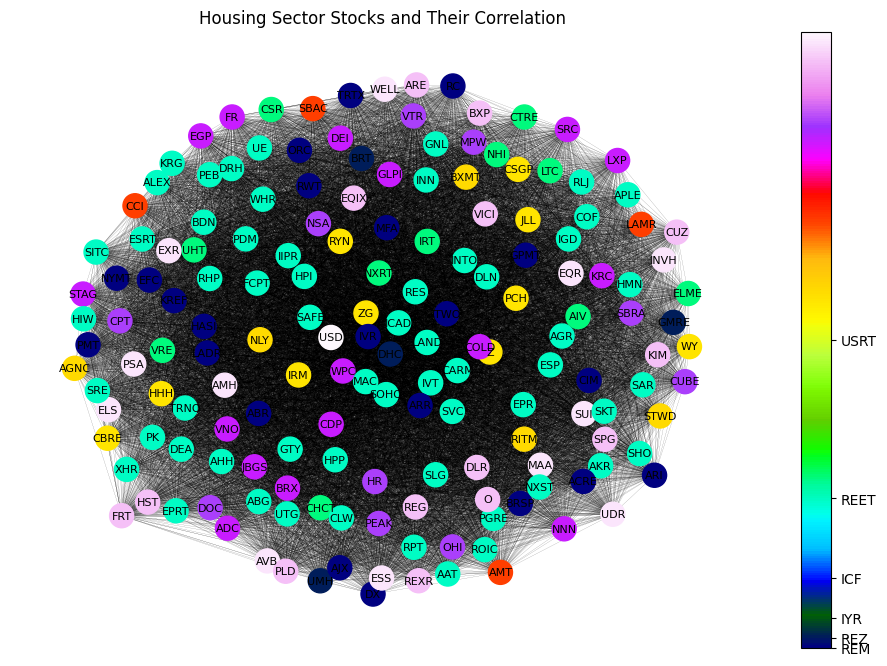

In [16]:
# Your colormap
cmap = plt.cm.gist_ncar

# Normalize your data to the colormap range
norm = plt.Normalize(vmin=min(flag_list), vmax=max(flag_list))

# Create a ScalarMappable
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You can leave it empty or set it to your data if needed

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
nx.draw(G, pos, node_color=flag_list, width=0.075, cmap=cmap,
        with_labels=True, font_size=8, vmin=min(flag_list), vmax=max(flag_list))
cbar = plt.colorbar(sm, ax=ax, location='right', ticks=BIN_MAP)
cbar.ax.set_yticklabels(ETF_LIST)
ax.set_title("Housing Sector Stocks and Their Correlation")
ax.set_facecolor("#e1e2e3")
plt.show()

In [84]:
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

In [88]:
#Removing top k nodes with max weight 
G_drop = G.copy()
dropped_df = df.copy()
for k in range(10):
    #Get array of node weight sums
    node_sum = []
    node_index = []
    for i, node in enumerate(G_drop.nodes()): 
        sum = 0
        for edge in G_drop.edges(f'{node}', data=True):
            sum += edge[2]['weight']
        node_sum.append(sum)
        node_index.append(node)

    #Get max of weights
    node_sum = np.array(node_sum)

    indices_to_drop = np.argpartition(node_sum, -5)[-5:]
    print(indices_to_drop)
    nodes_to_remove = np.array(node_index)[indices_to_drop]
    print(f'Dropping {nodes_to_remove}')
    #dropped_df = dropped_df[dropped_df['Ticker'] not in nodes_to_remove]
    dropped_df = filter_rows_by_values(dropped_df, "Ticker", nodes_to_remove)
    #dropped_df = dropped_df.drop(indices_to_drop)
    with pd.ExcelWriter("Data\\Correlation data - Copy.xlsx", mode='a') as writer:  
        dropped_df.to_excel(writer, sheet_name=f'Worst {5*k + 5} removed')


    G_drop.remove_nodes_from(list(nodes_to_remove))

[ 31  23  86 146 153]
Dropping ['Z' 'DHC' 'ZG' 'IVR' 'CARM']
[ 21 119  55  53  49]
Dropping ['SVC' 'SOHO' 'ICAD' 'MAC' 'INTO']
[156 112  22 118 133]
Dropping ['RES' 'ARR' 'USD' 'LAND' 'IIPR']
[121  15  21  17  50]
Dropping ['HASI' 'IVT' 'UHT' 'SAFE' 'TWO']
[ 27  67  91  48 111]
Dropping ['ABG' 'SKT' 'IRM' 'HPP' 'NXRT']
[ 66  36 133  72  84]
Dropping ['BRSP' 'IRT' 'GPMT' 'VNO' 'PK']
[64 38 67 26 11]
Dropping ['ESRT' 'CIM' 'PEB' 'MFA' 'PGRE']
[ 84 110  36  61  44]
Dropping ['NXST' 'NSA' 'JBGS' 'ESP' 'DEI']
[117  49 115  91 110]
Dropping ['ORC' 'EPR' 'BDN' 'CLW' 'RWT']
[84 87 12 56 76]
Dropping ['EXR' 'HHH' 'NYMT' 'PDM' 'SLG']


In [66]:
G.remove_nodes_from(np.array(['WPC', 'Z']))

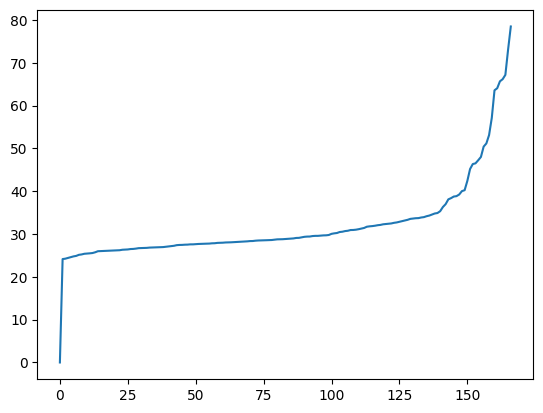

In [11]:
plt.plot(nx.laplacian_spectrum(G))